## All GSOD stations, one runtime

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import os
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix
from scipy.stats import pearsonr
import seaborn as sns
from weatherforce.standardization import standardize_coordinates
import weatherforce.analysis.scoring.contingency as wfcontingency
import weatherforce.analysis.stats as wfstats
import weatherforce.dataviz.graphs.scoring as wfscoring_graphs
import dask.array as da
import dask
from dask.diagnostics import ProgressBar
import glob
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

### Import observation GSOD data

Import the gsod data for the filtered stations (in Northern Peru, with enought data).

In [2]:
filtered_stations = pd.read_csv('/home/jovyan/data/share/heloise/ESA-WP11/GSOD/filtered_stations.csv')

### Import ACP stations

In [3]:
import pandas as pd
import xarray as xr
import cf_xarray.units  # noqa F401
import pint_xarray  # noqa F401

from weatherforce.datasources.catalogue import Catalogue
from weatherforce.datasources.pathfinder import DATA_DIR


class AcpStationSource:
    def open_time_range(self, start=None, end=None, units=False):
        """
        Open data for the given time range. If neither start or end are given all existing data will be returned.

        Args:
            start: Start of the time range. By default is None, which will return all the data from the first existing
                file.
            end: End of the time range. By default is None, which will take the data until the last existing file.
            units: Quantify pint units from metadata
        Returns:
            dataset containing the station data for the given time range.
            """
        filepaths = self._get_filepaths_in_time_range(start, end)
        ds = xr.open_mfdataset(filepaths)
        ds = ds.sel(time=slice(start, end))
        if units:
            ds = units = ds.pint.quantify()
        return ds

    def catalogue_url(self):
        """ Return the url of the catalogue source """
        return f"https://hub.weatherforce.net/manager/catalogue/sources/{self.source_id}"

    def _assert_valid_start(self, start, assets):
        if pd.Timestamp(start, tz="UTC") < assets.index.min(): # I think the station data is in UTC but to be checked
            self.log.warning(f"Start time is smaller than the minimum existing time: {assets.index.min()}")

    def _assert_valid_end(self, end, assets):
        if assets.index.max() < pd.Timestamp(end, tz="UTC"): # I think the station data is in UTC but to be checked
            self.log.warning(f"End time is bigger than the maximum existing time: {assets.index.max()}")

    def _get_filepaths_in_time_range(self, start, end):
        # After the new weather notebook image release this fuction must be replaced by the
        # Catalogue().list_time_sorted_source_assets method
        assets = self.list_time_sorted_catalogue_source_assets(self.source_id)
        self._assert_valid_start(start, assets)
        self._assert_valid_end(end, assets)
        assets_in_time_range = self._select_assets_in_range(assets, start, end)
        return self._get_assets_absolute_filepath(assets_in_time_range)
    
    def _select_assets_in_range(self, assets, start, end):
        assets_in_time_range = assets.loc[:end]
        if start is None:
            return assets_in_time_range
        else:
            return assets_in_time_range[start <= assets_in_time_range["values_end_time"]]
    
    def _get_assets_absolute_filepath(self, assets):
        return [DATA_DIR / file for file in assets.path]


    def list_time_sorted_catalogue_source_assets(self, source_id: str) -> pd.DataFrame:
        """
        Return a pandas dataframe with the assets of the catalogue
        ordered according to their start-values.

        It always renders a dataframe, even if there are no
        assets associated with the source. The dataframe is just
        empty.

        Args:
            source_id: Identifier of the catalogue data source

        Returns:
            An ordered pd.DataFrame of assets
        """

        assets = Catalogue().list_source_assets(source_id)

        number_assets = len(assets)

        if len(assets) == 0:
            assets = {"values_start_time": [],
                      "path": [],
                      "values_end_time": [],
                      "produced_at": [],
                      "source_id": []}

        assets = pd.DataFrame.from_dict(assets)
        assets["values_start_time"] = pd.to_datetime(assets["values_start_time"])

        time_ordered_assets = assets.set_index("values_start_time").sort_index()

        if not len(time_ordered_assets.index.unique()) == number_assets:
            raise ValueError("Cannot create the pandas dataframe without removing assets",
                             "as two or more assets share the same value",
                             "start time used as index. Use `list_source_assets` method instead.")

        return time_ordered_assets


class AcpF5Daily(AcpStationSource):
    def __init__(self, logger=None):
        self.source_id = "5302aa35-c98f-450f-a2b4-f87c38759cdb"


class AcpF7Daily(AcpStationSource):
    def __init__(self, logger=None):
        self.source_id = "002b6c65-64fe-4234-90bb-ddfba80f3ba0"

# Open F5 station all data
ds_F5 = AcpF5Daily().open_time_range()

# Open F7 station all data with units
ds_F7 = AcpF7Daily().open_time_range()

In [4]:
ds_F5.load()
print(f'Data from {ds_F5.time.min().values} to {ds_F5.time.max().values}.')
ds_F5

Data from 2017-04-20T00:00:00.000000000 to 2023-04-24T00:00:00.000000000.


<xarray.Dataset>
Dimensions:  (time: 2187)
Coordinates:
  * time     (time) datetime64[ns] 2017-04-20 2017-04-21 ... 2023-04-24
Data variables:
    tmax     (time) float32 30.9 31.3 30.8 31.3 31.0 ... 30.9 32.3 32.2 32.6
    tmin     (time) float32 22.7 21.2 20.2 21.3 22.1 ... 22.8 23.9 23.8 22.8
    2r       (time) float32 71.36 74.88 76.17 74.62 ... 80.21 74.17 74.25 76.96
    dpt      (time) float32 20.7 20.17 20.44 20.36 ... 21.94 22.03 21.9 22.07
    gust     (time) float32 19.3 16.1 20.9 20.9 24.1 ... 17.7 24.1 33.8 24.1
    tp       (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.6 1.2 0.0 0.0 0.0
    dswrf    (time) float32 983.0 806.0 909.0 679.0 ... 654.0 839.0 831.0 866.0
    etp      (time) float32 3.46 2.8 4.81 3.49 4.47 ... 4.08 2.67 4.34 3.82 4.65
Attributes:
    station name:  F5
    source file:   /home/jovyan/data/observations/customerStations/ACP/source...

In [5]:
ds_F7.load()
print(f'Data from {ds_F7.time.min().values} to {ds_F7.time.max().values}.')
ds_F7

Data from 2008-01-01T00:00:00.000000000 to 2023-04-24T00:00:00.000000000.


<xarray.Dataset>
Dimensions:  (time: 5560)
Coordinates:
  * time     (time) datetime64[ns] 2008-01-01 2008-01-02 ... 2023-04-24
Data variables:
    tmax     (time) float32 29.3 26.6 28.9 28.4 26.3 ... 31.6 32.4 32.7 32.9
    tmin     (time) float32 19.6 19.9 20.2 20.2 20.1 ... 22.3 24.0 23.2 22.2
    2r       (time) float32 68.41 69.73 67.21 68.0 ... 81.0 74.75 74.46 77.46
    dpt      (time) float32 17.18 16.68 16.84 16.81 ... 22.09 22.13 21.95 21.89
    gust     (time) float32 29.0 22.5 27.4 29.0 29.0 ... 19.3 24.1 17.7 22.5
    tp       (time) float32 0.4 0.0 0.0 0.0 0.0 0.0 ... 0.0 1.6 0.0 0.0 0.0 0.0
    dswrf    (time) float32 921.0 684.0 984.0 988.0 ... 647.0 813.0 771.0 808.0
    etp      (time) float32 5.04 2.99 4.83 4.68 4.4 ... 3.94 2.64 4.06 3.74 4.35
Attributes:
    station name:  F7
    source file:   /home/jovyan/data/observations/customerStations/ACP/source...

### Distribution by cluster

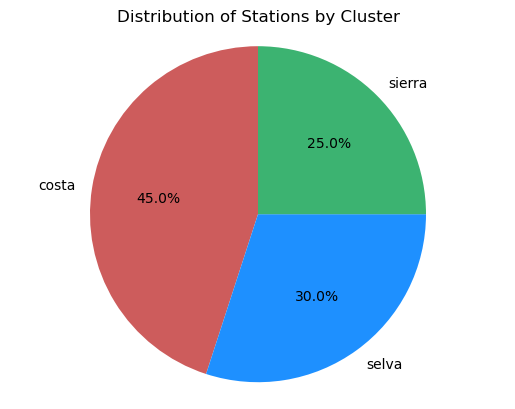

In [6]:
cluster_counts = filtered_stations['cluster'].value_counts()
colors = ['indianred', 'dodgerblue', 'mediumseagreen']

cluster_counts['costa'] += 2

fig, ax = plt.subplots()
ax.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
ax.axis('equal')
plt.title('Distribution of Stations by Cluster')
plt.show()

fig.savefig('distribution_stations_by_cluster.png')

### Functions

In [7]:
newpath = f'/home/jovyan/data/share/heloise/ESA-WP11/Anomaly/figures_gsod_c3s_downscaled' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [8]:
def get_c3s_data_downscaled(par: str = 'tp', year: int = 1993, month: int = 1):

    '''
    Get C3S seasonal forecast (ECMWF SEAS5) for a specific month and year.

    Args:
        par: the parameter name, by default 'tp'
        year: desired year, by default '1993'
        month: desired month, by default 1 (january)

    Returns:
        C3S data for a specific month and year
    '''
    filepath = f'/home/jovyan/data/share/Martin/ESA/WP11/c3s_seasonal/downscaled/{par}/peru_north/1km/method_002/{year}/{month:02d}'
    filename = f'tp_c3s_downscaled_peru_north_{year}_{month:02d}.nc'
    
    ds = xr.open_dataset(os.path.join(filepath, filename))
    
    return ds

In [9]:
def compute_metrics(predicted, reference):
    """
    Compute the specified metric between the predicted and reference fields.

    Args:
        - predicted (array-like):predicted field.
        - reference (array-like): reference field.
        
    Returns:
        - result: float, computed metric result, normalized bias, mae, rmse, pearson score, skill score
    """
    
    # Calculate the normalized bias
    bias = predicted - reference
    min_val = np.min(bias)
    max_val = np.max(bias)
    normalized_bias = (bias - min_val) / (max_val - min_val)
    
    # Calculate MAE
    mae = mean_absolute_error(reference, predicted)

    # Calculate RMSE
    mse = mean_squared_error(reference, predicted)
    rmse = math.sqrt(mse)

    # Calculate Pearson's correlation
    corr, _ = pearsonr(reference, predicted)

    # Calculate Skill Score
    rmse2 = rmse ** 2 # root-mean-square error 
    sdev2 = np.std(reference, ddof=1) ** 2 # standard deviation
    if sdev2 != 0:
        skill_score = 1 - rmse2 / sdev2 # SS = 1 - RMSE^2/SDEV^2
    else:
        skill_score = np.nan
    
    #brier_score = xs.brier_score(reference, predicted)

    return normalized_bias, mae, rmse, corr, skill_score#, brier_score


In [10]:
def plot_station_data(time, predicted, reference, station_name):
    """
    Plot the station data including forecasted and observed precipitation along with the absolute bias.

    Args:
        - time (array-like): Time axis values for the plot.
        - predicted (array-like): Forecasted precipitation values.
        - reference (array-like): Observed precipitation values.

    Returns:
        None (displays the plot).

    """
    abs_bias = np.abs(predicted - reference)

    fig = plt.figure()
    plt.plot(time, predicted, label='forecast', color='b')
    plt.plot(time, reference, label='observation', color='g')
    plt.plot(time, abs_bias, label='absolute bias', color='r', ls=':')
    plt.xlabel('Month')
    plt.ylabel('tp (mm)')
    plt.title(f'Cumulative monthly mean precipitation \nRuntime month {time[0]}')
    plt.legend()
    #plt.show()
    fig.savefig(f'/home/jovyan/data/share/heloise/ESA-WP11/Anomaly/metrics_month_mean/tp_station_month_{time[0]}_{station_name}.png')
    plt.close()


In [11]:
def plot_model_error(predicted, reference, date, station_name):
    """
    Plot the error between model predictions and observations with model overestimation and underestimation.

    Args:
        predicted (array-like): Model predicted values.
        reference (array-like): Observed reference values.
        date (array-like): Dates or timestamps corresponding to the predicted and reference values.

    Returns:
        None (displays the error plot).
    """
    error = predicted - reference
    zeros = [0] * len(date)
    
    fig = plt.figure()
    overestimate = plt.fill_between(date, error, zeros, where=(error >= zeros),
                                    color='#ff7051', alpha=0.6, interpolate=True)
    underestimate = plt.fill_between(date, error, zeros, where=(zeros >= error),
                                     color='#5797ff', alpha=0.6, interpolate=True)
    
    max_error = max(abs(error)) + 2
    min_error = min(abs(error)) - 2
    plt.ylim(top=max_error, bottom=min_error)
    plt.xlabel('Time (month)')
    plt.ylabel('Error (mm)')
    plt.legend([overestimate, underestimate],
               ["Model that overestimates precipitation", "Model that underestimates precipitation"],
               loc="best", prop={'size': 10}, title_fontsize=10)
    plt.title("Model error")
    plt.grid(True)
    #plt.show()
    fig.savefig(f'/home/jovyan/data/share/heloise/ESA-WP11/Anomaly/metrics_month_mean/tp_station_error_month_{date[0]}_{station_name}.png')
    plt.close()

In [12]:
def plot_bias(metrics_df, time):
    """
    Plot the biases for all stations in the same plot.

    Args:
        - metrics_df (DataFrame): DataFrame containing the metrics for each station, including the normalized bias.

    Returns:
        None (displays the plot).

    """
    fig_bias, ax_bias = plt.subplots()
    cluster_colors = {'costa': 'indianred', 'sierra': 'dodgerblue', 'selva': 'mediumseagreen'}

    for index, row in metrics_df.iterrows():
        station_name = row['name']
        cluster = row['cluster']
        color_clust = cluster_colors.get(cluster, 'gray')
        ax_bias.plot(time, metrics_df.norm_bias[index], color=color_clust)

    legend_elements = [
        plt.Line2D([0], [0], color='indianred', lw=2, label='Cluster Costa'),
        plt.Line2D([0], [0], color='dodgerblue', lw=2, label='Cluster Sierra'),
        plt.Line2D([0], [0], color='mediumseagreen', lw=2, label='Cluster Selva')
    ]
    ax_bias.legend(handles=legend_elements)

    ax_bias.set_xlabel('Month')
    ax_bias.set_ylabel('Normalized bias')
    ax_bias.set_title(f'Observation-Forecast biases \nRuntime month {time[0]}')
    #plt.show()
    fig_bias.savefig(f'/home/jovyan/data/share/heloise/ESA-WP11/Anomaly/metrics_month_mean/tp_bias_runtime_month_{time[0]}.png')

In [13]:
def evaluate_forecast(obs, model, month, percentage: float = 0.5):
    '''
    Evaluate the forecast performance of a model by comparing it to the observed values. 
    It checks whether the model's predictions fall within a specified percentage range 
    around the observed values for each time step.

    Args:
        obs (panda series): observed reference values.
        model (xarray): model prediction values.
        percentage (float): percentage range around the observed values within which the 
        model's predictions are considered accurate, by default 0.5 (50%)

    Returns:
        evaluate_tab: list containing the evaluation results for each time step (good or wrong forecast)
    '''
    
    evaluate_tab = []
    
    for t in range (1, 6):
        
        tp_obs = obs.values[t]
        tp_pred = model.isel(lead_time=t)
        
        delta = tp_obs*percentage
        
        if (tp_obs == 0):
            if (tp_pred >5):
                evaluate_tab.append('wrong forecast - should be zero')
            else : 
                evaluate_tab.append('good forecast - no rain')
        
        elif ((tp_obs <= 5) & (tp_pred <=5)):
            evaluate_tab.append('good forecast - no rain')
        
        elif (((tp_obs - delta) < tp_pred) & (tp_pred < (tp_obs + delta))):
            if (tp_pred<= tp_obs):
                evaluate_tab.append('good forecast - underestimate')
            else:
                 evaluate_tab.append('good forecast - overestimate')
            
        else:
            if (tp_pred<tp_obs):
                 evaluate_tab.append('wrong forecast - below')
            else:
                 evaluate_tab.append('wrong forecast - above')
    
    return evaluate_tab

In [14]:
def plot_contingency(truth, prediction, digit_labels, name_labels):    
    """       
    Plot and return the contingency table based on the digits of observation truth and predicted labels.

    Args:
        truth (array-like): Observation truth labels.
        prediction (array-like): Predicted labels.
        digit_labels (array-like): Digit labels used in the confusion matrix.
        name_labels (array-like): Name labels corresponding to the digit labels.

    Returns:
        array-like: The confusion matrix.

    """    

    # Calculate confusion matrix
    cm = confusion_matrix(truth, prediction, labels=digit_labels, normalize=None)
    
    plt.figure()
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cbar=None, cmap="Blues", linewidths=1, linecolor="w")
    
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Observation')
    ax.set_title('Contingency table')
    ax.xaxis.set_ticklabels(name_labels)
    ax.yaxis.set_ticklabels(name_labels)
    #plt.show()
    plt.close()

    return cm

In [15]:
def preprocess(ds,downscaled:bool = True):
    
    if 'tprate' in list(ds.keys()):

        nb_days = ds.time.dt.days_in_month
        # m/s to mm/month
        conversion_factor = 1e3 * 3600 * 24

        # Apply conversion
        converted_ds = ds * conversion_factor * nb_days
        converted_ds.attrs["units"] = "mm"
        # rename latitude and longitude to lat /lon (WF format)
        converted_ds = standardize_coordinates(converted_ds)

        # rename variable to tp
        ds = converted_ds.rename_vars(name_dict={'tprate': 'tp'})        
    
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        run_time = ds.indexes["time"][0]
        ds = ds.assign_coords({"run_time": run_time})
        ds = ds.expand_dims("run_time")
        ds = ds.assign_coords({"time": [i for i in range(1, 7)]})
        #ds = ds.assign_coords({"offset": ("time", [f"{i}MS" for i in range(6)])})
        ds = ds.rename({"time": "lead_time"})
        # put negative values to zeros
        ds['tp'] = xr.where(ds['tp'] < 0, 0, ds['tp'])

    return ds

In [16]:
def get_c3s_run_time(month:int = 1, downscaled:bool = True):
    
    if downscaled:
        ds = xr.open_mfdataset(f'/home/jovyan/data/share/Martin/ESA/WP11/c3s_seasonal/downscaled/tp/peru_north/1km/method_002/*/{month:02d}/*.nc', preprocess=preprocess)
    else:
        ds = xr.open_mfdataset( f'/home/jovyan/data/forecast/c3s_seasonal/peru_north/*/*/{month:02d}/*.nc', preprocess=preprocess)

    with ProgressBar():
        ds = ds.load()
    return ds

In [27]:
def monthly_tp(month:int = 1):

    # For the current runtime month
    print('Current runtime _____________________________________________________________ \n')
    end_month = (month + 5) % 12 or 12
    print(f'Runtime month: {month}, until {end_month}')

    # Import all the downscaled forecast data for this runtime month
    ds = get_c3s_run_time(month, downscaled=True)
    ds_mean = ds.mean(dim='run_time')

    metrics = []
    grid_method = 'nearest'
    time = [(month + val) % 12 or 12 for val in range(6)]
    time = list(map(str, time))

    for index, row in filtered_stations.iterrows():

        ####### Forecast and observation

        # Station name and localisation
        print('_____________________________________________________________________________ \n')
        station_name, cluster = row['name'], row['cluster']
        print(f'\nStation {station_name}, cluster {cluster}')
        lat_obs, lon_obs = row['lat'], row['lon']
        print(f'Latitude: {lat_obs}°, Longitude: {lon_obs}° \n')

        # Create the equivalent point from forecast
        ds_k = ds_mean.sel(lon=lon_obs, lat=lat_obs, method=grid_method)
        print(f'Forecast \nLatitude: {ds_k.lat.values}°, Longitude: {ds_k.lon.values}° \n')

        # Select the period of the forecast data in the gsod data
        df = pd.read_csv(f'/home/jovyan/data/share/heloise/ESA-WP11/GSOD/tp_month_mean_1991_2020_{station_name}.csv')
        
            # Open the reference dataset for the corresponding month

        if (month < end_month):
            filtered_df = df[(df['time'] >= month) & (df['time'] <= end_month)]
        else:
            filtered_df1 = df[df['time'] >= month]
            filtered_df2 = df[df['time'] <= end_month]
            filtered_df = pd.concat([filtered_df1, filtered_df2])
                    
        if (filtered_df.size == 0):
            print(f'No historical data for {month} for this station.')
        else: 

            ####### Metrics

            model = ds_k.tp
            reference = filtered_df.tp

            df = pd.DataFrame({'model': pd.Series(model.values), 'obs': pd.Series(reference.values)})

            #### Confusion table, rain and no rain
            thresholds = 5
            columns = ['obs', 'model']
            binned = wfstats.digitize(df, bins=thresholds, columns=columns)
            labels = [f"<{thresholds} mm", f"≥ {thresholds} mm"]
            digits = [0,1]

            cm_bin = plot_contingency(binned['obs'], binned['model'], digits, labels)
            tp, fp, fn, tn = cm_bin.ravel()
            stats = wfcontingency.ConfusionMatrixStatistics(tp, fp, fn, tn)
            ACC = stats.ACC * 100
            print(f'Accuracy for the contingency table rain/no rain: {"{:.2f}".format(ACC)} %\n')

            #### Contingency table, rain levels
            thresholds = [5, 20, 40, 60, 80, 120, 200]
            columns = ['obs', 'model']
            binned = wfstats.digitize(df, bins=thresholds, columns=columns)
            labels = [f"<{thresholds[0]}"] + [f"{value}" for value in thresholds]
            digits = [0,1,2,3,4,5,6,7]

            cm_levels = plot_contingency(binned['obs'], binned['model'], digits, labels)
            stats_list = wfcontingency.generate_stats_list(df, obs_col='obs', pred_col='model', bins=thresholds)
            #fig, ax = wfscoring_graphs.plot_ROC(stats_list, bins=thresholds, figsize=(5,5))

            (bias, mae, rmse, pears, skill) = compute_metrics(model, reference)

            eval_forecast = evaluate_forecast(reference, model, month)
            print(f'Evaluation of the model for each month: \n{eval_forecast}\n')

            metrics.append({'name': station_name, 'cluster': cluster, 'mae': mae, 'rmse': rmse, 'accuracy': ACC, 
                            'pearson corr': pears, 'skill score': skill, 'norm_bias': bias, 'evaluation': eval_forecast, 'contingency':cm_levels})

            ####### Plot

            # Plot the station and forecast data for the runtime defined previously, with absolute bias
            plot_station_data(time, model, reference, station_name)
            # Plot the error of the model
            plot_model_error(model, reference, time, station_name)

    
    acp_station = ['ACP_F5', 'ACP_F7']
    lat_acp = -7.017523, -7.040693
    lon_acp = -79.581263, -79.535942

    for idx, station_name in enumerate(acp_station):
        # Station name and localisation
        print('_____________________________________________________________________________ \n')
        cluster = 'costa'
        print(f'\nStation {station_name}, cluster {cluster}')
        lat_obs, lon_obs = lat_acp[idx], lon_acp[idx]
        print(f'Latitude: {lat_obs}°, Longitude: {lon_obs}° \n')

        # Create the equivalent point from forecast
        ds_k = ds_mean.sel(lon=lon_obs, lat=lat_obs, method=grid_method)
        print(f'Forecast \nLatitude: {ds_k.lat.values}°, Longitude: {ds_k.lon.values}° \n')

        # Select the period of the forecast data in the acp data
        df = pd.read_csv(f'/home/jovyan/data/share/heloise/ESA-WP11/ACP/tp_month_mean_2017_2023_ACP_F5.csv')
        if (month < end_month):
            filtered_df = df[(df['month'] >= month) & (df['month'] <= end_month)]
        else:
            filtered_df1 = df[df['month'] >= month]
            filtered_df2 = df[df['month'] <= end_month]
            filtered_df = pd.concat([filtered_df1, filtered_df2])

        if (filtered_df.size == 0):
            print(f'No historical data for {month} for this station.')
        else: 

            ####### Metrics

            model = ds_k.tp
            reference = filtered_df.tp

            df = pd.DataFrame({'model': pd.Series(model.values), 'obs': pd.Series(reference.values)})

            #### Confusion table, rain and no rain
            thresholds = 5
            columns = ['obs', 'model']
            binned = wfstats.digitize(df, bins=thresholds, columns=columns)
            labels = [f"<{thresholds} mm", f"≥ {thresholds} mm"]
            digits = [0,1]

            cm_bin = plot_contingency(binned['obs'], binned['model'], digits, labels)
            tp, fp, fn, tn = cm_bin.ravel()
            stats = wfcontingency.ConfusionMatrixStatistics(tp, fp, fn, tn)
            ACC = stats.ACC * 100
            print(f'Accuracy for the contingency table rain/no rain: {"{:.2f}".format(ACC)} %\n')

            #### Contingency table, rain levels
            thresholds = [5, 20, 40, 60, 80, 120, 200]
            columns = ['obs', 'model']
            binned = wfstats.digitize(df, bins=thresholds, columns=columns)
            labels = [f"<{thresholds[0]}"] + [f"{value}" for value in thresholds]
            digits = [0,1,2,3,4,5,6,7]

            cm_levels = plot_contingency(binned['obs'], binned['model'], digits, labels)
            stats_list = wfcontingency.generate_stats_list(df, obs_col='obs', pred_col='model', bins=thresholds)
            #fig, ax = wfscoring_graphs.plot_ROC(stats_list, bins=thresholds, figsize=(5,5))

            (bias, mae, rmse, pears, skill) = compute_metrics(model, reference)

            eval_forecast = evaluate_forecast(reference, model, month)
            print(f'Evaluation of the model for each month: \n{eval_forecast}\n')

            metrics.append({'name': station_name, 'cluster': cluster, 'mae': mae, 'rmse': rmse, 'accuracy': ACC, 
                            'pearson corr': pears, 'skill score': skill, 'norm_bias': bias, 'evaluation': eval_forecast, 'contingency':cm_levels})

            ####### Plot

            # Plot the station and forecast data for the runtime defined previously, with absolute bias
            plot_station_data(time, model, reference, station_name)
            # Plot the error of the model
            plot_model_error(model, reference, time, station_name)

    
    
    # Create the metrics dataframe
    sorted_metrics = sorted(metrics, key=lambda x: abs(x['rmse']))
    df_metrics = pd.DataFrame(sorted_metrics)
    df_metrics.to_csv(f'/home/jovyan/data/share/heloise/ESA-WP11/Anomaly/metrics_month_mean/metrics_month_{month}.csv')

    # Plot the bias for all stations 
    plot_bias(df_metrics, time)
    
    print('_____________________________________________________________________________ \n')
    print('Scoring and results by cluster')
    print('_____________________________________________________________________________ \n')


    # Calculate the means by cluster
    columns_to_mean = ['mae', 'rmse','accuracy', 'pearson corr', 'skill score']
    averages_by_cluster = df_metrics.groupby('cluster')[columns_to_mean].mean()
    averages_by_cluster = averages_by_cluster.applymap(lambda x: round(x, 3))


    df_metrics['evaluate'] = [[1 if 'good' in val else 0 for val in sublist] for sublist in df_metrics['evaluation']]
    evaluate_mean_cluster = df_metrics.groupby('cluster')['evaluate'].apply(lambda x: np.mean(x.tolist(), axis=0))
    good_values = [['{:.0f}%'.format(val*100) for val in sublist] for sublist in evaluate_mean_cluster]

    averages_by_cluster['% of good forecast'] = [good_values[i] for i in range(len(averages_by_cluster))]
    print(averages_by_cluster)
    averages_by_cluster.to_csv(f'/home/jovyan/data/share/heloise/ESA-WP11/Anomaly/metrics_month_mean/metrics_by_cluster_month_{month}.csv')

    # Contingency table by cluster, sum of the stations in the cluster
    cm_cluster = df_metrics.groupby('cluster')['contingency'].sum()
    cluster_name = ['costa', 'selva', 'sierra']
    for i in range (len(cm_cluster)):
        thresholds = [5, 20, 40, 60, 80, 120, 200]
        labels = [f"<{thresholds[0]}"] + [f"{value}" for value in thresholds]

        plt.figure()
        ax = plt.subplot()
        sns.heatmap(cm_cluster[i], annot=True, ax=ax, cbar=None, cmap="Blues", linewidths=1, linecolor="w")

        ax.set_xlabel('Prediction')
        ax.set_ylabel('Observation')
        ax.set_title(f'Contingency table for stations in {cluster_name[i]}')
        ax.xaxis.set_ticklabels(labels)
        ax.yaxis.set_ticklabels(labels)
        plt.show()
        
    # Mean bias by cluster for the period of the runtime
    all_bias = df_metrics.groupby('cluster')['norm_bias'].apply(lambda x: np.mean(x.tolist(), axis=0))

    plt.plot(time, all_bias[0], color='indianred', label='Cluster Costa')
    plt.plot(time, all_bias[1], color='mediumseagreen', label='Cluster Selva')
    plt.plot(time, all_bias[2], color='dodgerblue', label='Cluster Sierra')

    plt.legend()
    plt.xlabel('Month')
    plt.ylabel('Normalized bias')
    plt.title(f'Observation-Forecast biases \nRuntime month {month}')
    plt.show()


In [18]:
import folium
from folium.plugins import MarkerCluster
import base64
from folium import IFrame
import pandas as pd

def map_month(month:int = 1):
    gsod_stations = pd.read_csv('/home/jovyan/data/share/heloise/ESA-WP11/GSOD/filtered_stations.csv')
    acp_station = ['ACP_F5', 'ACP_F7']
    lat_ACP_F5, lon_ACP_F5 = -7.017523, -79.581263
    lat_ACP_F7, lon_ACP_F7 = -7.040693, -79.535942

    # Create a map centered on the average coordinates
    mean_lat = gsod_stations['lat'].mean()
    mean_lon = gsod_stations['lon'].mean()
    map_stations = folium.Map(location=[mean_lat, mean_lon], zoom_start=6)

    # Create feature groups for each zone
    costa_group = folium.FeatureGroup(name='Cost Stations')
    sierra_group = folium.FeatureGroup(name='Sierra Stations')
    selva_group = folium.FeatureGroup(name='Selva Stations')

    acp_group = folium.FeatureGroup(name='ACP Stations')

    width = 300
    height = 200    

    # Iterate over stations in the metadata DataFrame
    for index, row in gsod_stations.iterrows():
        station_name = row['name']
        lat = row['lat']
        lon = row['lon']
        cluster = row['cluster']
        
        # Define the paths to the frames
        frame_path = f'/home/jovyan/data/share/heloise/ESA-WP11/Anomaly/metrics_month_mean/tp_station_month_{month}_{station_name}.png'
        frame_path_2 = f'/home/jovyan/data/share/heloise/ESA-WP11/Anomaly/metrics_month_mean/tp_station_error_month_{month}_{station_name}.png'

        # Read the images and encode them in base64
        with open(frame_path, 'rb') as f:
            encoded = base64.b64encode(f.read()).decode('UTF-8')

        with open(frame_path_2, 'rb') as f2:
            encoded_2 = base64.b64encode(f2.read()).decode('UTF-8')

        # Define the HTML content for the popups
        html = f'''
        <div style="text-align: center;">
        <h4>{station_name}</h4>
        <img src="data:image/png;base64,{encoded}" style="max-width: 100%; max-height: 100%;">
        <img src="data:image/png;base64,{encoded_2}" style="max-width: 100%; max-height: 100%;">
        </div>
        '''

        # Define the HTML content for the popups
        #html = '<div style="text-align: center;"><h4 style="font-size: 12px;">{}</h4><img src="data:image/png;base64,{}" style="max-width: 100%; max-height: 100%;"></div>'.format(station_name, encoded)
        # Create the iframes and popups
        iframe = folium.IFrame(html, width=400, height=300)
        popup = folium.Popup(iframe, max_width=400)

        # Check the zone membership and add to the corresponding group
        if (cluster == 'costa'):
            # Create the marker with the popups
            folium.Marker(location=[lat, lon], tooltip=station_name, popup = popup, icon=folium.Icon(color='red')).add_to(costa_group)

        elif (cluster == 'sierra'):
            # Create the marker with the popups
            folium.Marker(location=[lat, lon], tooltip=station_name, popup = popup, icon=folium.Icon(color='blue')).add_to(sierra_group)

        elif (cluster == 'selva'):
            # Create the marker with the popups
            folium.Marker(location=[lat, lon], tooltip=station_name, popup = popup, icon=folium.Icon(color='green')).add_to(selva_group)
 
    
    station_name = 'ACP_F5'
    # Define the paths to the frames
    frame_path = f'/home/jovyan/data/share/heloise/ESA-WP11/Anomaly/metrics_month_mean/tp_station_month_{month}_{station_name}.png'
    frame_path_2 = f'/home/jovyan/data/share/heloise/ESA-WP11/Anomaly/metrics_month_mean/tp_station_error_month_{month}_{station_name}.png'

    # Read the images and encode them in base64
    with open(frame_path, 'rb') as f:
        encoded = base64.b64encode(f.read()).decode('UTF-8')

    with open(frame_path_2, 'rb') as f2:
        encoded_2 = base64.b64encode(f2.read()).decode('UTF-8')

    # Define the HTML content for the popups
    html = f'''
    <div style="text-align: center;">
    <h4>{station_name}</h4>
    <img src="data:image/png;base64,{encoded}" style="max-width: 100%; max-height: 100%;">
    <img src="data:image/png;base64,{encoded_2}" style="max-width: 100%; max-height: 100%;">
    </div>
    '''
    iframe = folium.IFrame(html, width=400, height=300)
    popup = folium.Popup(iframe, max_width=400)
    folium.Marker(location=[lat_ACP_F5, lon_ACP_F5], tooltip=station_name, popup = popup, icon=folium.Icon(color='orange')).add_to(acp_group)

    
    
    station_name = 'ACP_F7'
    # Define the paths to the frames
    frame_path = f'/home/jovyan/data/share/heloise/ESA-WP11/Anomaly/metrics_month_mean/tp_station_month_{month}_{station_name}.png'
    frame_path_2 = f'/home/jovyan/data/share/heloise/ESA-WP11/Anomaly/metrics_month_mean/tp_station_error_month_{month}_{station_name}.png'

    # Read the images and encode them in base64
    with open(frame_path, 'rb') as f:
        encoded = base64.b64encode(f.read()).decode('UTF-8')

    with open(frame_path_2, 'rb') as f2:
        encoded_2 = base64.b64encode(f2.read()).decode('UTF-8')

    # Define the HTML content for the popups
    html = f'''
    <div style="text-align: center;">
    <h4>{station_name}</h4>
    <img src="data:image/png;base64,{encoded}" style="max-width: 100%; max-height: 100%;">
    <img src="data:image/png;base64,{encoded_2}" style="max-width: 100%; max-height: 100%;">
    </div>
    '''
    # Create the iframes and popups
    iframe = folium.IFrame(html, width=400, height=300)
    popup = folium.Popup(iframe, max_width=400)
    folium.Marker(location=[lat_ACP_F7, lon_ACP_F7], tooltip=station_name, popup = popup, icon=folium.Icon(color='orange')).add_to(acp_group)

    # Add the groups to the map
    costa_group.add_to(map_stations)
    sierra_group.add_to(map_stations)
    selva_group.add_to(map_stations)

    acp_group.add_to(map_stations)

    # Display and save the map
    folium.LayerControl().add_to(map_stations)
    map_stations.save(f'map_tp_month_{month}.html')
    map_stations

### Monthly tp

### Test

In [19]:
ds = get_c3s_run_time(6, True)

[########################################] | 100% Completed | 4.87 sms


In [20]:
ds

<xarray.Dataset>
Dimensions:    (lat: 1200, lon: 960, lead_time: 6, run_time: 28)
Coordinates:
  * lat        (lat) float64 -3.404 -3.412 -3.421 -3.429 ... -13.38 -13.39 -13.4
  * lon        (lon) float64 -82.0 -81.99 -81.98 -81.97 ... -74.02 -74.01 -74.0
  * lead_time  (lead_time) int64 1 2 3 4 5 6
  * run_time   (run_time) datetime64[ns] 1993-06-01 1994-06-01 ... 2020-06-01
Data variables:
    tp         (run_time, lead_time, lat, lon) float64 nan nan ... 190.1 190.5

In [21]:
ds_mean = ds.mean(dim='run_time')

In [22]:
ds_mean

<xarray.Dataset>
Dimensions:    (lat: 1200, lon: 960, lead_time: 6)
Coordinates:
  * lat        (lat) float64 -3.404 -3.412 -3.421 -3.429 ... -13.38 -13.39 -13.4
  * lon        (lon) float64 -82.0 -81.99 -81.98 -81.97 ... -74.02 -74.01 -74.0
  * lead_time  (lead_time) int64 1 2 3 4 5 6
Data variables:
    tp         (lead_time, lat, lon) float64 nan nan nan ... 177.7 179.1 179.5

In [23]:
ds2 = ds.isel(lead_time=4)

In [24]:
#one_point = ds2.sel(lat=-7.42, lon=-77.1, method='nearest')
one_point = ds2.sel(lat=-12.02, lon=-77.11, method='nearest')

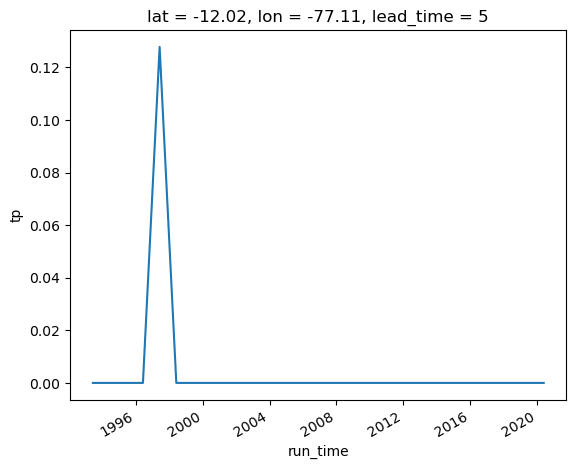

In [25]:
one_point.tp.plot()

### Evaluate C3S downscaled WorldClim model

Current runtime _____________________________________________________________ 

Runtime month: 1, until 6
[########################################] | 100% Completed | 11.16 s
_____________________________________________________________________________ 


Station PEDRO CANGA, cluster costa
Latitude: -3.553°, Longitude: -80.381° 

Forecast 
Latitude: -3.55416666666666°, Longitude: -80.37916666666666° 

Accuracy for the contingency table rain/no rain: 83.33 %

Evaluation of the model for each month: 
['good forecast - overestimate', 'good forecast - overestimate', 'wrong forecast - above', 'wrong forecast - above', 'wrong forecast - above']

_____________________________________________________________________________ 


Station CAPITAN MONTES, cluster costa
Latitude: -4.577°, Longitude: -81.254° 

Forecast 
Latitude: -4.579166666666666°, Longitude: -81.25416666666666° 

Accuracy for the contingency table rain/no rain: 83.33 %

Evaluation of the model for each month: 
['wrong forecast -

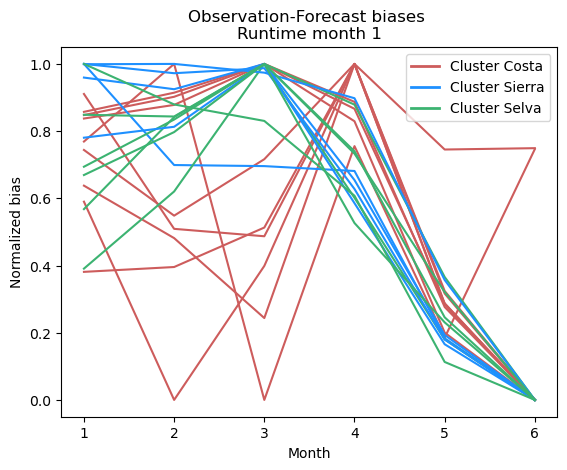

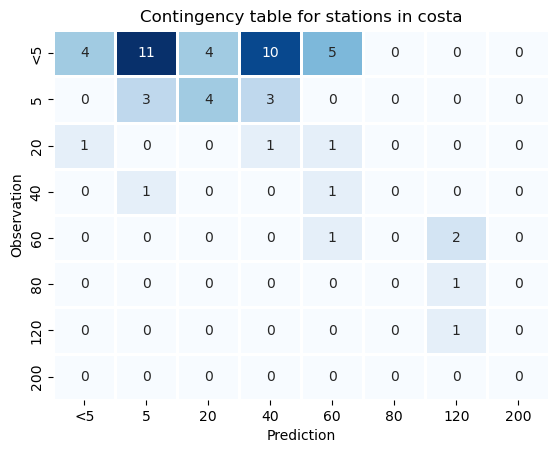

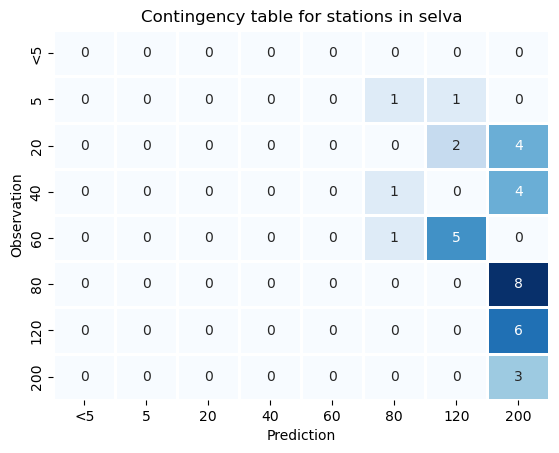

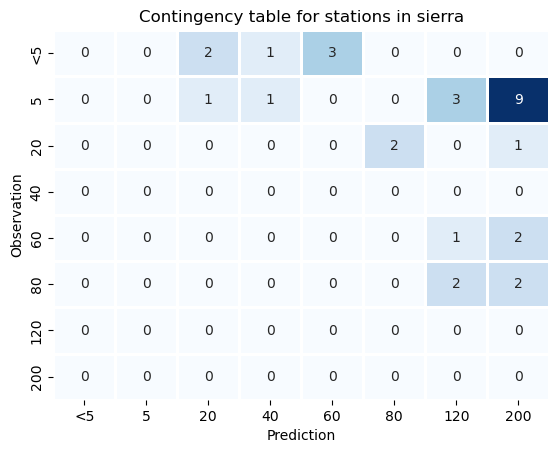

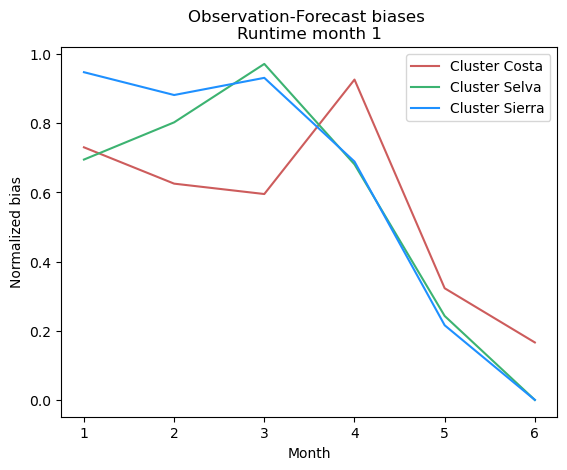

Current runtime _____________________________________________________________ 

Runtime month: 2, until 7
[########################################] | 100% Completed | 10.45 s
_____________________________________________________________________________ 


Station PEDRO CANGA, cluster costa
Latitude: -3.553°, Longitude: -80.381° 

Forecast 
Latitude: -3.55416666666666°, Longitude: -80.37916666666666° 

Accuracy for the contingency table rain/no rain: 66.67 %

Evaluation of the model for each month: 
['wrong forecast - above', 'wrong forecast - above', 'wrong forecast - above', 'wrong forecast - above', 'wrong forecast - above']

_____________________________________________________________________________ 


Station CAPITAN MONTES, cluster costa
Latitude: -4.577°, Longitude: -81.254° 

Forecast 
Latitude: -4.579166666666666°, Longitude: -81.25416666666666° 

Accuracy for the contingency table rain/no rain: 83.33 %

Evaluation of the model for each month: 
['good forecast - underestimat

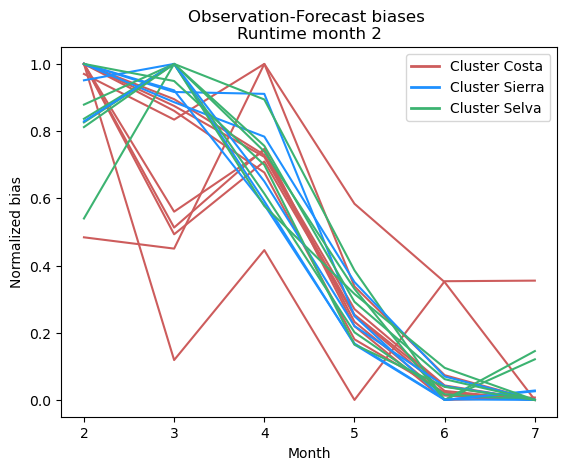

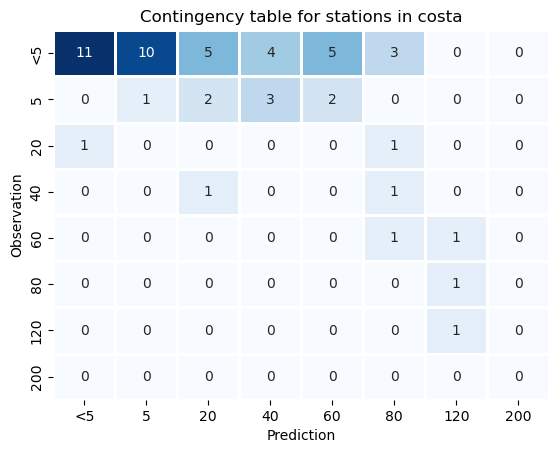

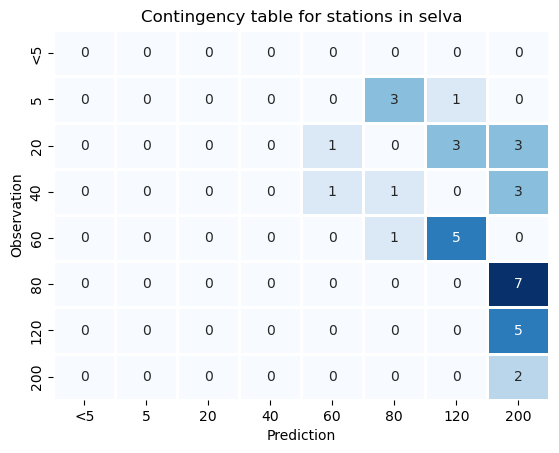

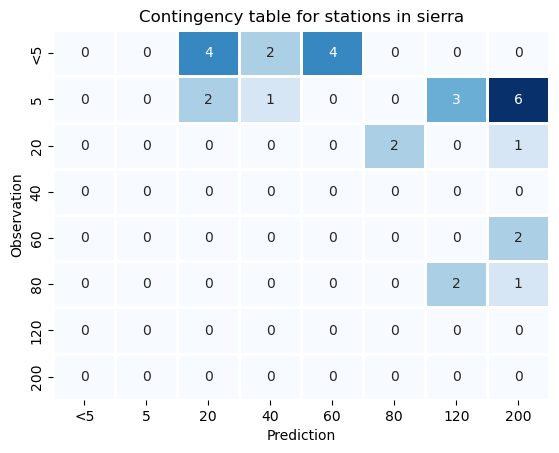

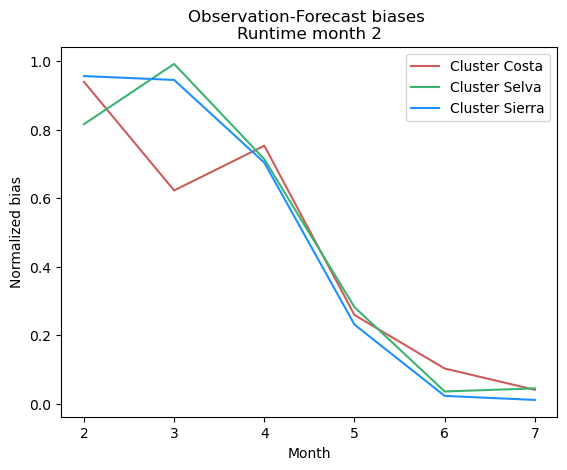

Current runtime _____________________________________________________________ 

Runtime month: 3, until 8
[########################################] | 100% Completed | 11.66 s
_____________________________________________________________________________ 


Station PEDRO CANGA, cluster costa
Latitude: -3.553°, Longitude: -80.381° 

Forecast 
Latitude: -3.55416666666666°, Longitude: -80.37916666666666° 

Accuracy for the contingency table rain/no rain: 66.67 %

Evaluation of the model for each month: 
['wrong forecast - above', 'wrong forecast - above', 'wrong forecast - above', 'wrong forecast - above', 'wrong forecast - above']

_____________________________________________________________________________ 


Station CAPITAN MONTES, cluster costa
Latitude: -4.577°, Longitude: -81.254° 

Forecast 
Latitude: -4.579166666666666°, Longitude: -81.25416666666666° 

Accuracy for the contingency table rain/no rain: 83.33 %

Evaluation of the model for each month: 
['wrong forecast - above', 'wr

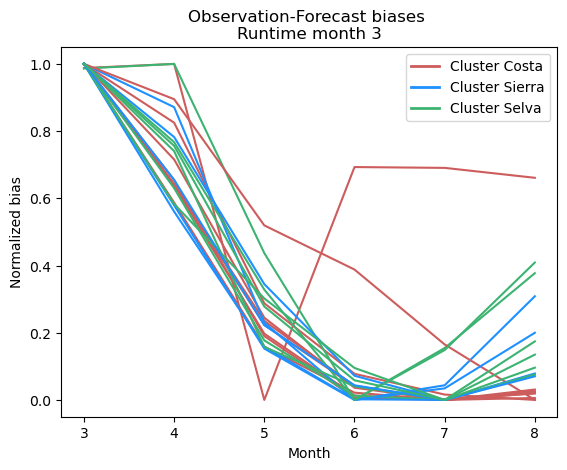

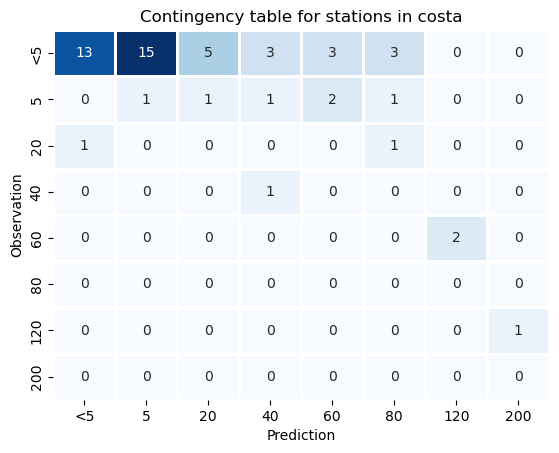

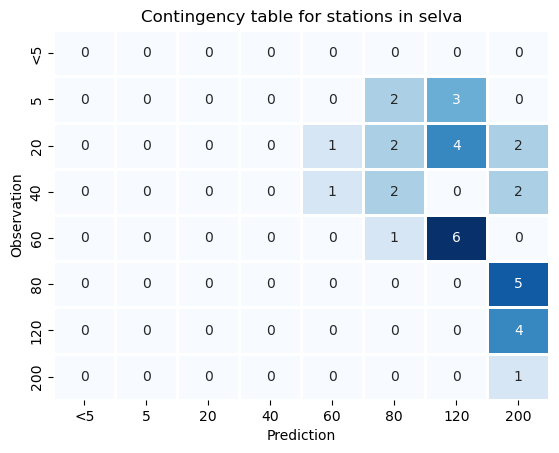

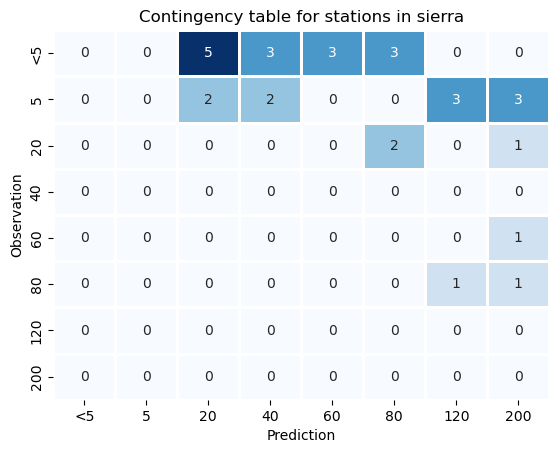

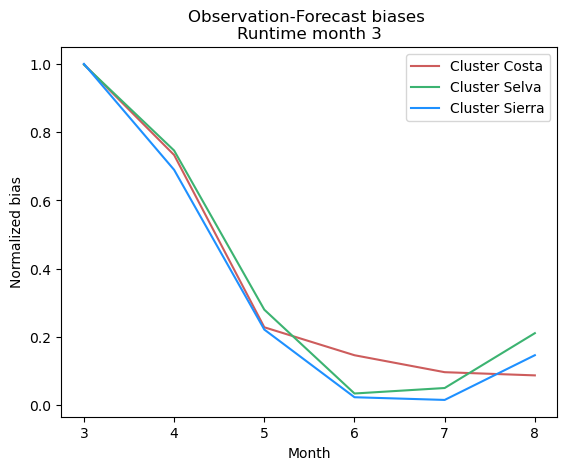

Current runtime _____________________________________________________________ 

Runtime month: 4, until 9
[########################################] | 100% Completed | 11.25 s
_____________________________________________________________________________ 


Station PEDRO CANGA, cluster costa
Latitude: -3.553°, Longitude: -80.381° 

Forecast 
Latitude: -3.55416666666666°, Longitude: -80.37916666666666° 

Accuracy for the contingency table rain/no rain: 50.00 %

Evaluation of the model for each month: 
['wrong forecast - above', 'wrong forecast - above', 'wrong forecast - above', 'wrong forecast - above', 'wrong forecast - above']

_____________________________________________________________________________ 


Station CAPITAN MONTES, cluster costa
Latitude: -4.577°, Longitude: -81.254° 

Forecast 
Latitude: -4.579166666666666°, Longitude: -81.25416666666666° 

Accuracy for the contingency table rain/no rain: 83.33 %

Evaluation of the model for each month: 
['wrong forecast - below', 'go

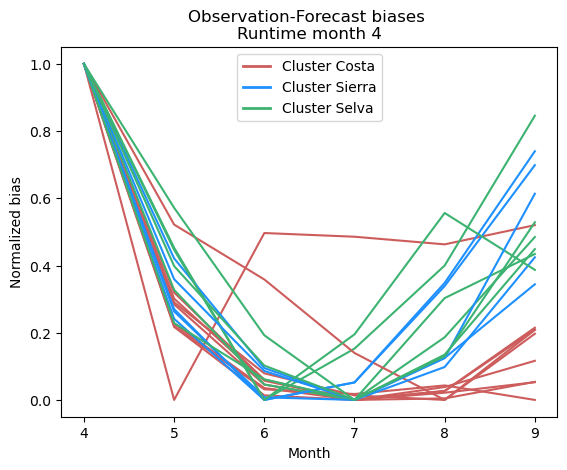

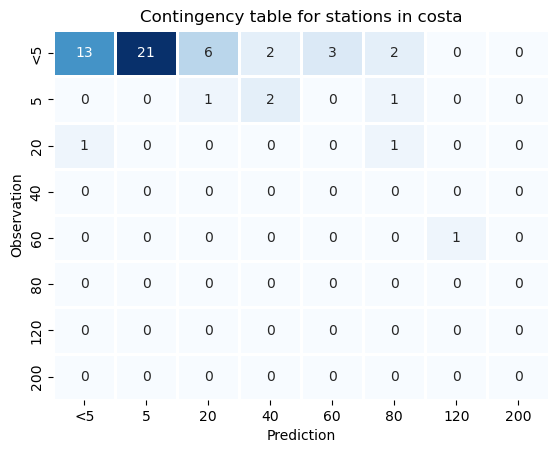

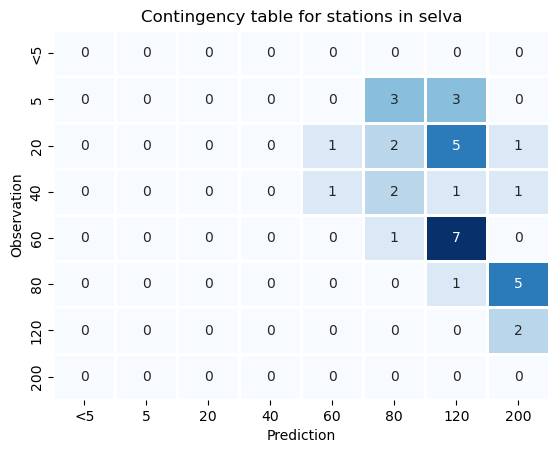

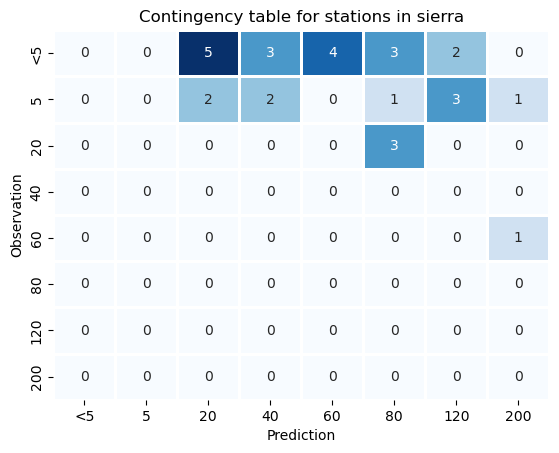

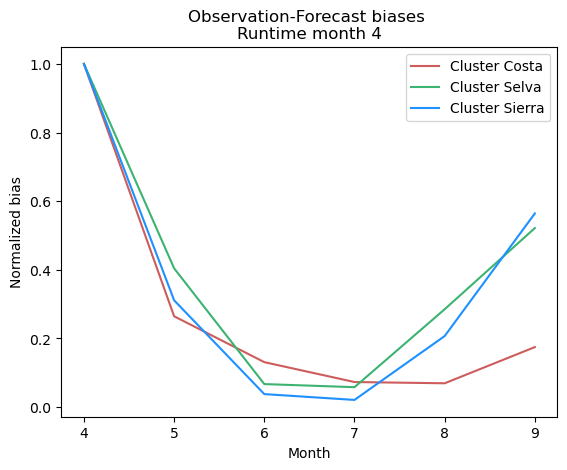

Current runtime _____________________________________________________________ 

Runtime month: 5, until 10
[########################################] | 100% Completed | 10.86 s
_____________________________________________________________________________ 


Station PEDRO CANGA, cluster costa
Latitude: -3.553°, Longitude: -80.381° 

Forecast 
Latitude: -3.55416666666666°, Longitude: -80.37916666666666° 

Accuracy for the contingency table rain/no rain: 33.33 %

Evaluation of the model for each month: 
['wrong forecast - above', 'wrong forecast - above', 'wrong forecast - above', 'wrong forecast - above', 'wrong forecast - above']

_____________________________________________________________________________ 


Station CAPITAN MONTES, cluster costa
Latitude: -4.577°, Longitude: -81.254° 

Forecast 
Latitude: -4.579166666666666°, Longitude: -81.25416666666666° 

Accuracy for the contingency table rain/no rain: 83.33 %

Evaluation of the model for each month: 
['good forecast - no rain', '

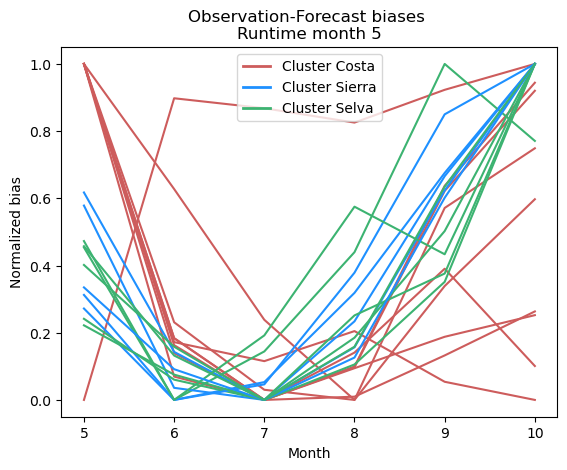

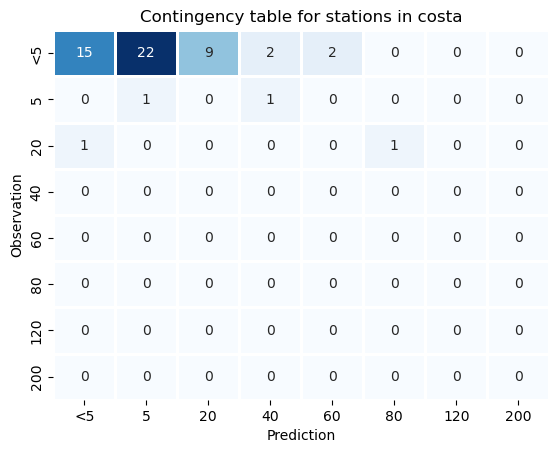

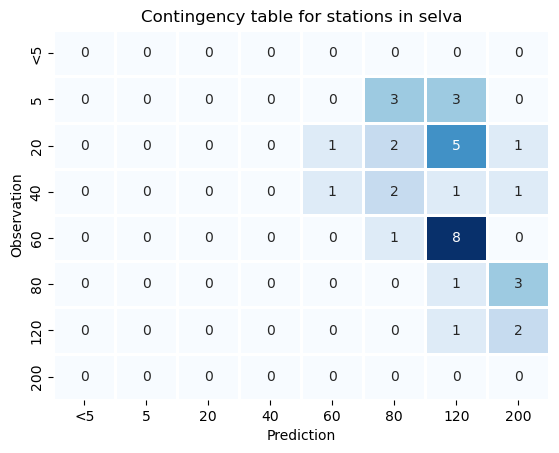

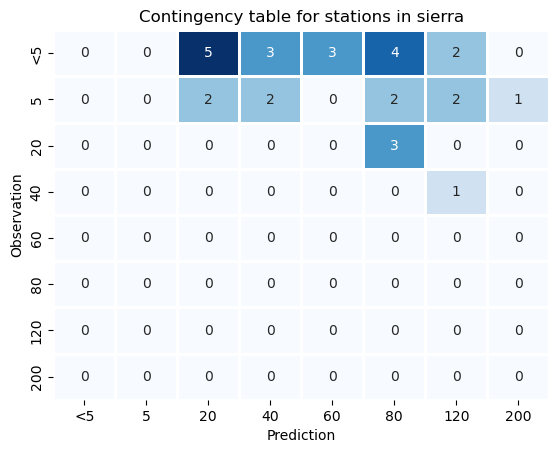

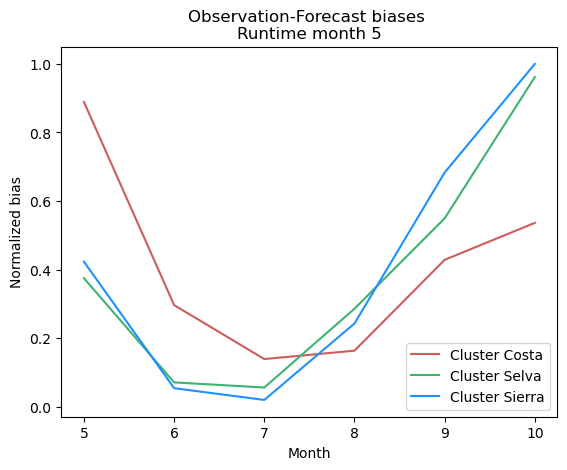

Current runtime _____________________________________________________________ 

Runtime month: 6, until 11
[########################################] | 100% Completed | 11.88 s
_____________________________________________________________________________ 


Station PEDRO CANGA, cluster costa
Latitude: -3.553°, Longitude: -80.381° 

Forecast 
Latitude: -3.55416666666666°, Longitude: -80.37916666666666° 

Accuracy for the contingency table rain/no rain: 33.33 %

Evaluation of the model for each month: 
['wrong forecast - above', 'wrong forecast - above', 'wrong forecast - above', 'wrong forecast - above', 'wrong forecast - above']

_____________________________________________________________________________ 


Station CAPITAN MONTES, cluster costa
Latitude: -4.577°, Longitude: -81.254° 

Forecast 
Latitude: -4.579166666666666°, Longitude: -81.25416666666666° 

Accuracy for the contingency table rain/no rain: 100.00 %

Evaluation of the model for each month: 
['good forecast - no rain', 

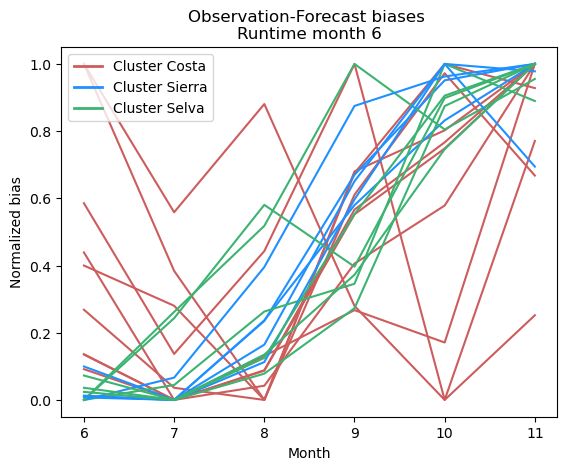

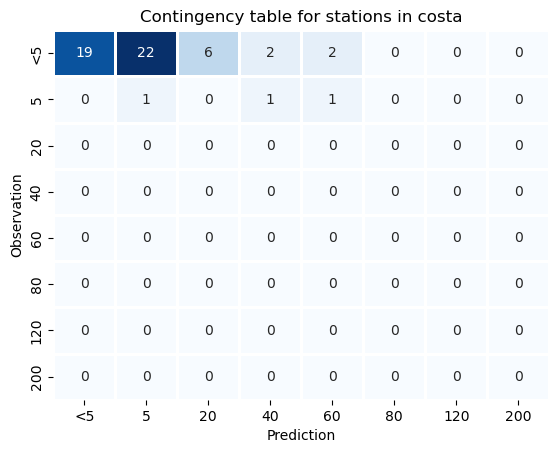

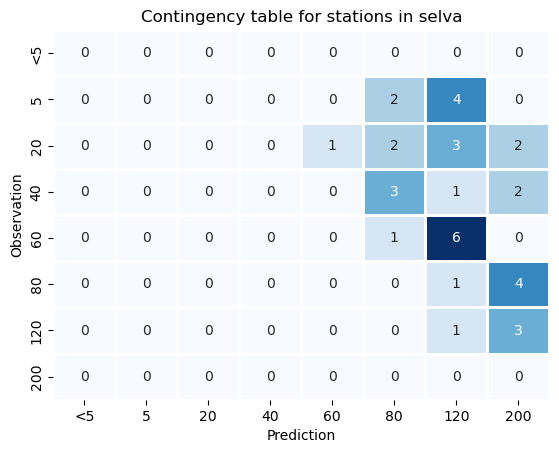

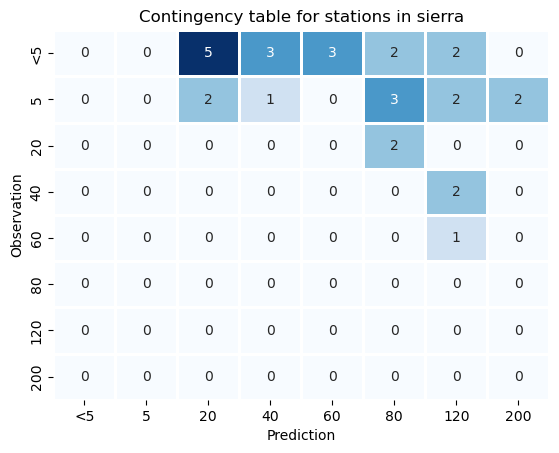

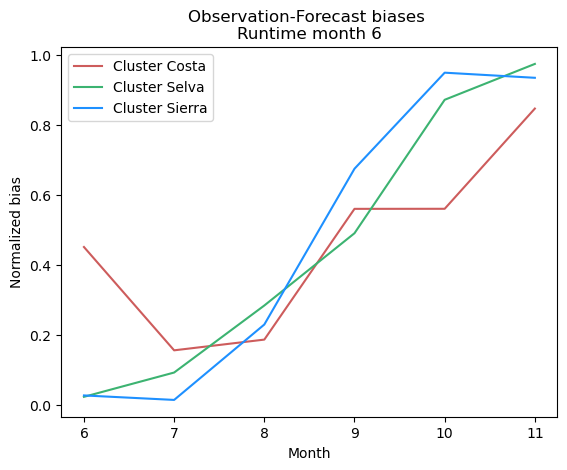

Current runtime _____________________________________________________________ 

Runtime month: 7, until 12
[########################################] | 100% Completed | 11.47 s
_____________________________________________________________________________ 


Station PEDRO CANGA, cluster costa
Latitude: -3.553°, Longitude: -80.381° 

Forecast 
Latitude: -3.55416666666666°, Longitude: -80.37916666666666° 

Accuracy for the contingency table rain/no rain: 50.00 %

Evaluation of the model for each month: 
['wrong forecast - above', 'wrong forecast - above', 'wrong forecast - above', 'wrong forecast - above', 'wrong forecast - above']

_____________________________________________________________________________ 


Station CAPITAN MONTES, cluster costa
Latitude: -4.577°, Longitude: -81.254° 

Forecast 
Latitude: -4.579166666666666°, Longitude: -81.25416666666666° 

Accuracy for the contingency table rain/no rain: 83.33 %

Evaluation of the model for each month: 
['good forecast - no rain', '

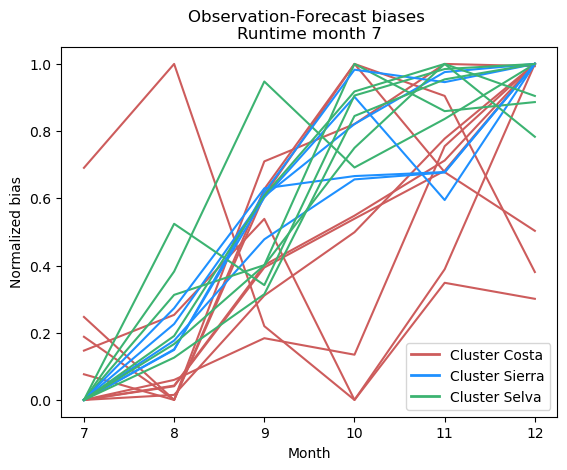

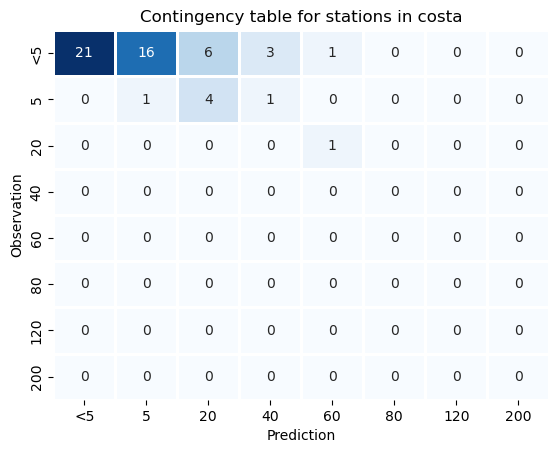

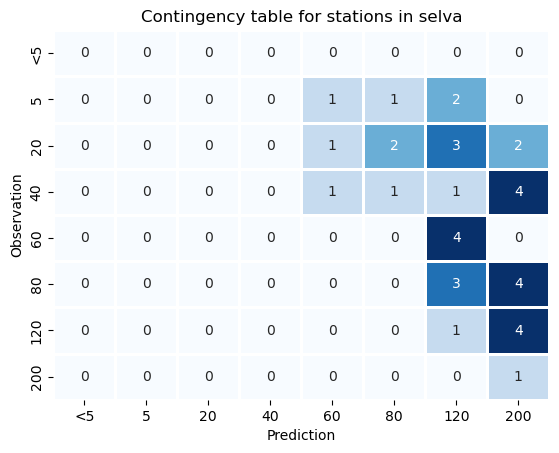

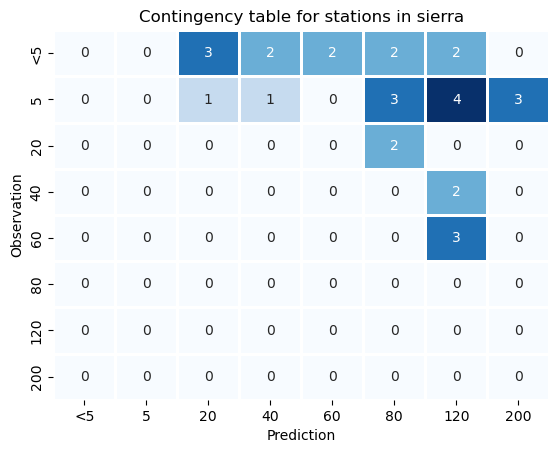

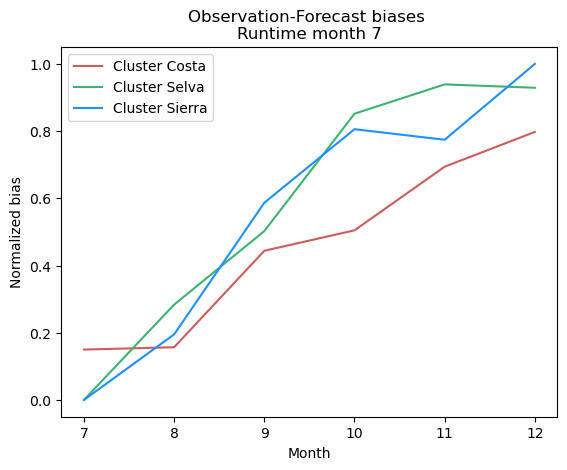

Current runtime _____________________________________________________________ 

Runtime month: 8, until 1
[########################################] | 100% Completed | 11.98 s
_____________________________________________________________________________ 


Station PEDRO CANGA, cluster costa
Latitude: -3.553°, Longitude: -80.381° 

Forecast 
Latitude: -3.55416666666666°, Longitude: -80.37916666666666° 

Accuracy for the contingency table rain/no rain: 66.67 %

Evaluation of the model for each month: 
['wrong forecast - above', 'wrong forecast - above', 'wrong forecast - above', 'wrong forecast - above', 'good forecast - overestimate']

_____________________________________________________________________________ 


Station CAPITAN MONTES, cluster costa
Latitude: -4.577°, Longitude: -81.254° 

Forecast 
Latitude: -4.579166666666666°, Longitude: -81.25416666666666° 

Accuracy for the contingency table rain/no rain: 83.33 %

Evaluation of the model for each month: 
['good forecast - no rai

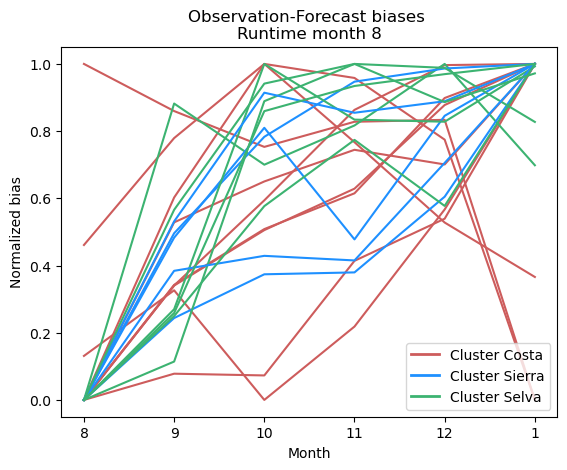

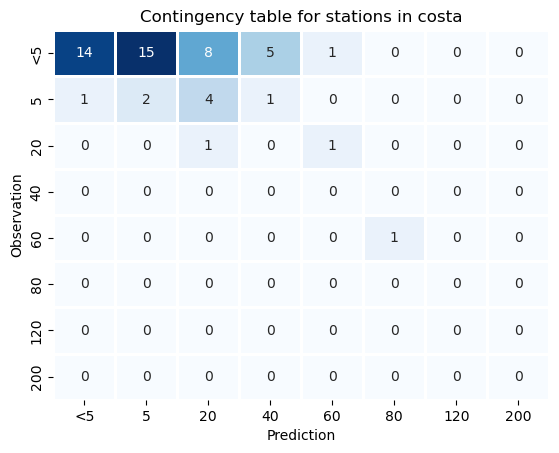

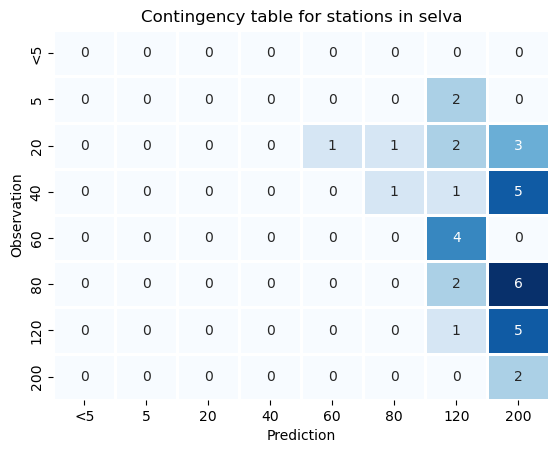

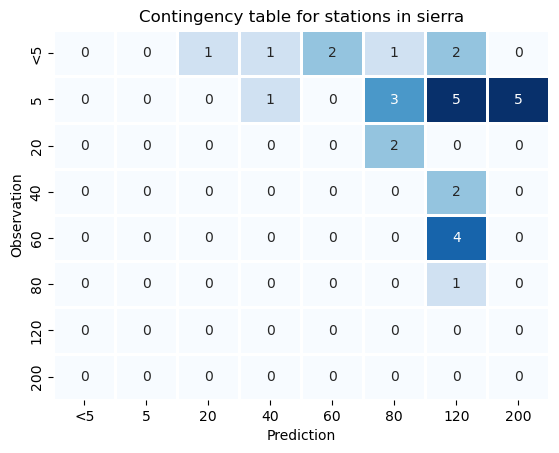

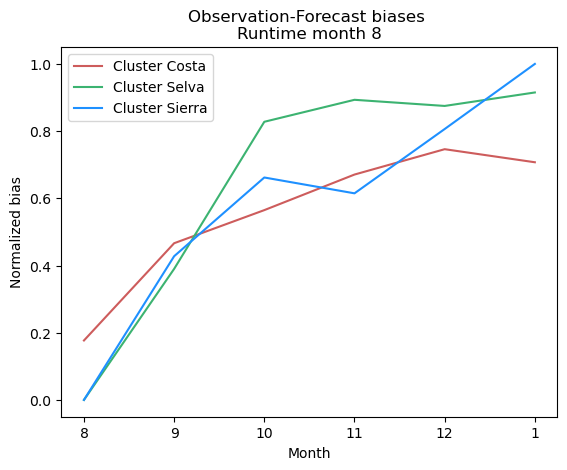

Current runtime _____________________________________________________________ 

Runtime month: 9, until 2
[########################################] | 100% Completed | 11.97 s
_____________________________________________________________________________ 


Station PEDRO CANGA, cluster costa
Latitude: -3.553°, Longitude: -80.381° 

Forecast 
Latitude: -3.55416666666666°, Longitude: -80.37916666666666° 

Accuracy for the contingency table rain/no rain: 66.67 %

Evaluation of the model for each month: 
['wrong forecast - above', 'wrong forecast - above', 'wrong forecast - above', 'good forecast - overestimate', 'good forecast - underestimate']

_____________________________________________________________________________ 


Station CAPITAN MONTES, cluster costa
Latitude: -4.577°, Longitude: -81.254° 

Forecast 
Latitude: -4.579166666666666°, Longitude: -81.25416666666666° 

Accuracy for the contingency table rain/no rain: 83.33 %

Evaluation of the model for each month: 
['good forecast -

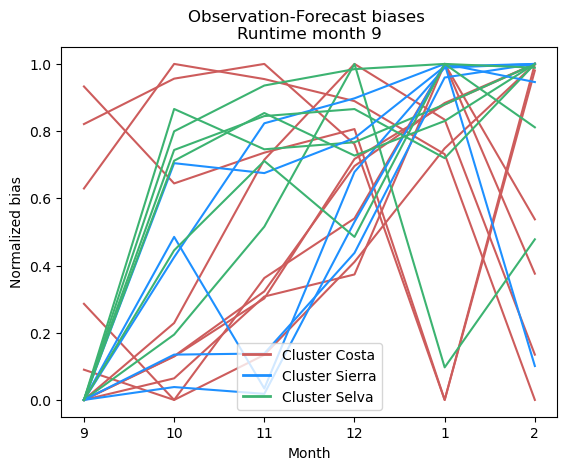

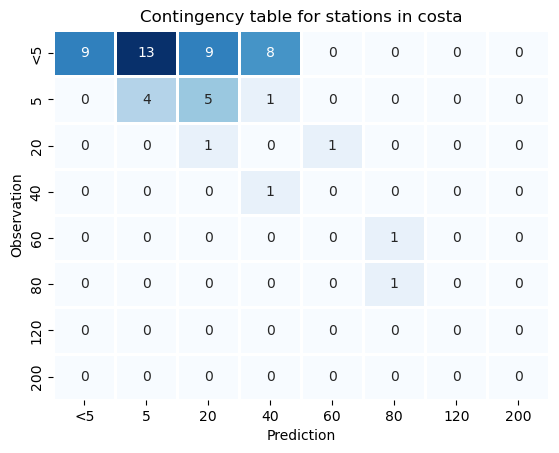

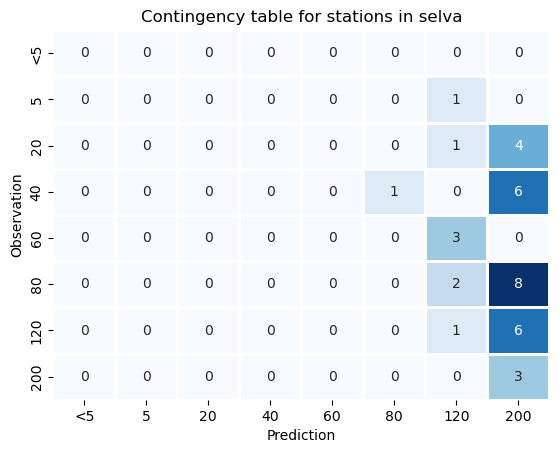

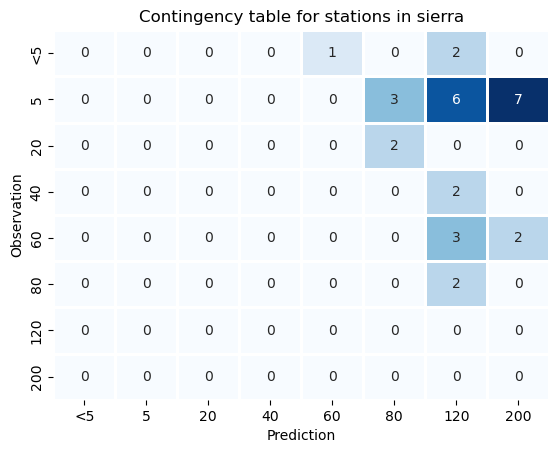

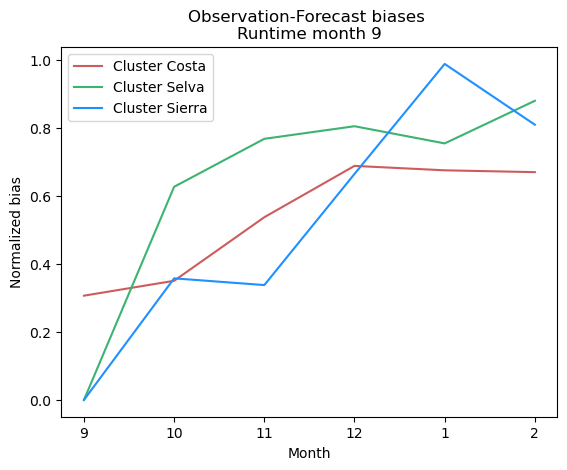

Current runtime _____________________________________________________________ 

Runtime month: 10, until 3
[########################################] | 100% Completed | 11.97 s
_____________________________________________________________________________ 


Station PEDRO CANGA, cluster costa
Latitude: -3.553°, Longitude: -80.381° 

Forecast 
Latitude: -3.55416666666666°, Longitude: -80.37916666666666° 

Accuracy for the contingency table rain/no rain: 83.33 %

Evaluation of the model for each month: 
['wrong forecast - above', 'wrong forecast - above', 'wrong forecast - above', 'good forecast - underestimate', 'good forecast - overestimate']

_____________________________________________________________________________ 


Station CAPITAN MONTES, cluster costa
Latitude: -4.577°, Longitude: -81.254° 

Forecast 
Latitude: -4.579166666666666°, Longitude: -81.25416666666666° 

Accuracy for the contingency table rain/no rain: 83.33 %

Evaluation of the model for each month: 
['good forecast 

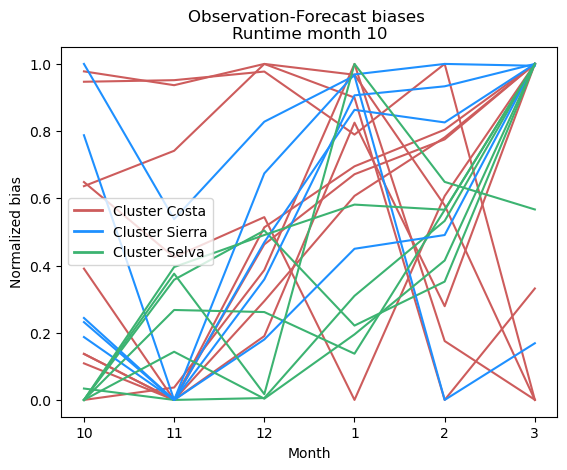

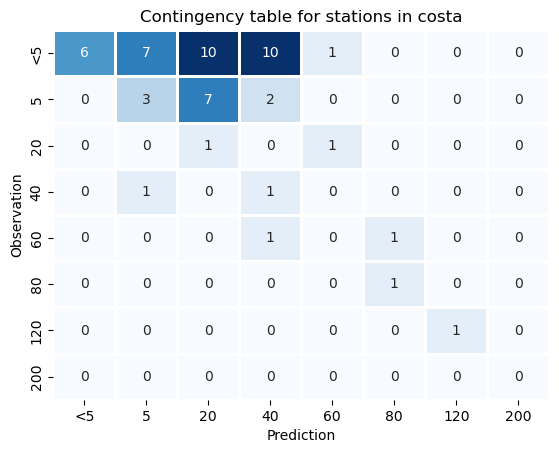

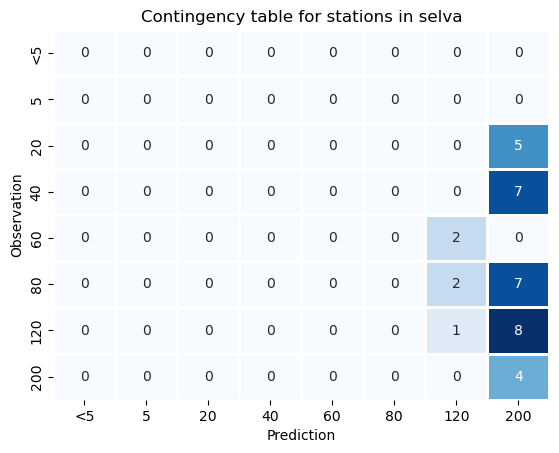

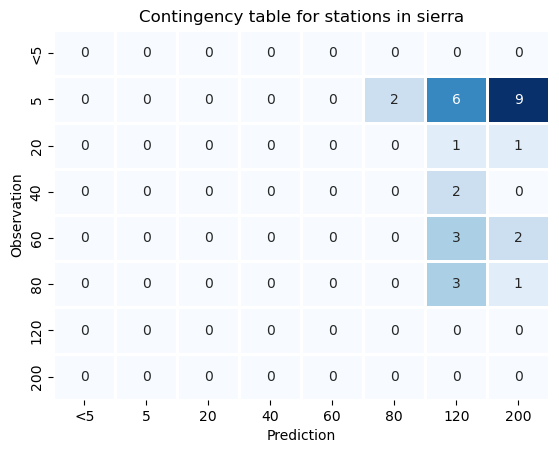

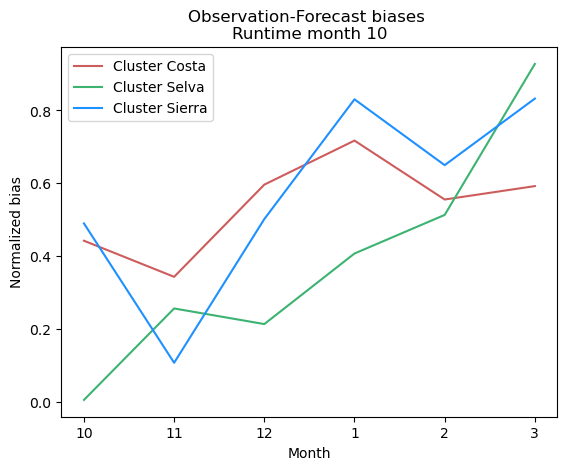

Current runtime _____________________________________________________________ 

Runtime month: 11, until 4
[########################################] | 100% Completed | 13.00 s
_____________________________________________________________________________ 


Station PEDRO CANGA, cluster costa
Latitude: -3.553°, Longitude: -80.381° 

Forecast 
Latitude: -3.55416666666666°, Longitude: -80.37916666666666° 

Accuracy for the contingency table rain/no rain: 100.00 %

Evaluation of the model for each month: 
['wrong forecast - above', 'wrong forecast - above', 'good forecast - overestimate', 'good forecast - overestimate', 'wrong forecast - above']

_____________________________________________________________________________ 


Station CAPITAN MONTES, cluster costa
Latitude: -4.577°, Longitude: -81.254° 

Forecast 
Latitude: -4.579166666666666°, Longitude: -81.25416666666666° 

Accuracy for the contingency table rain/no rain: 66.67 %

Evaluation of the model for each month: 
['wrong forecast

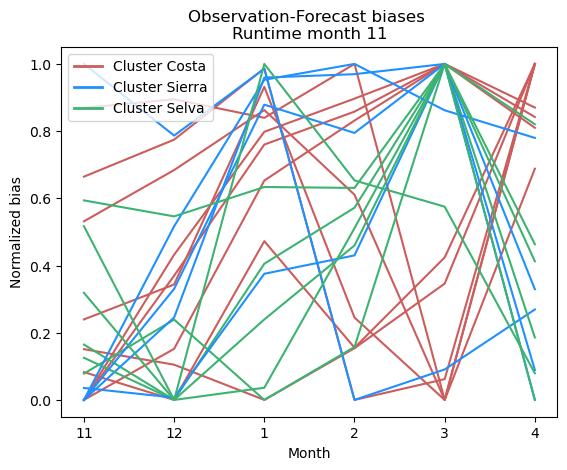

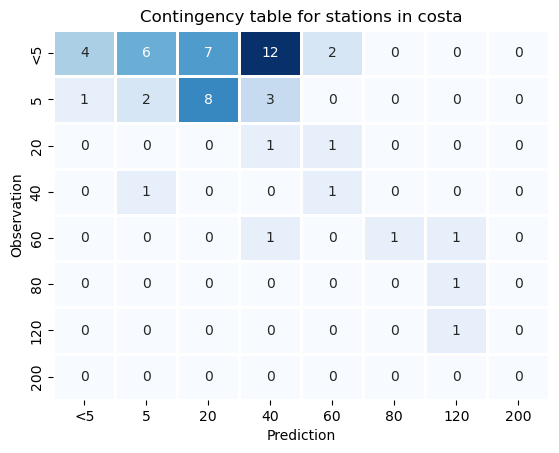

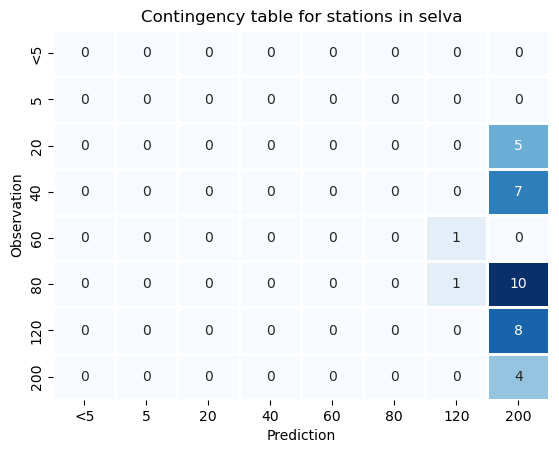

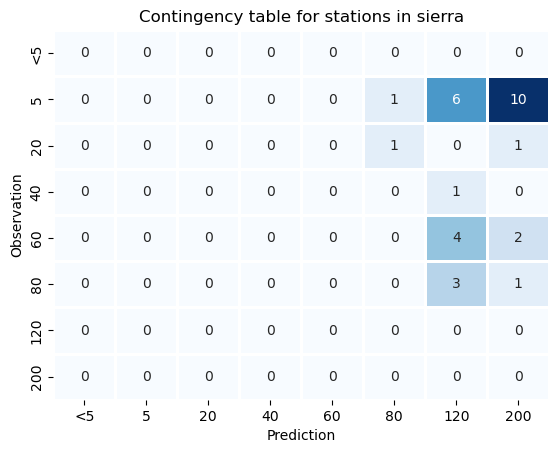

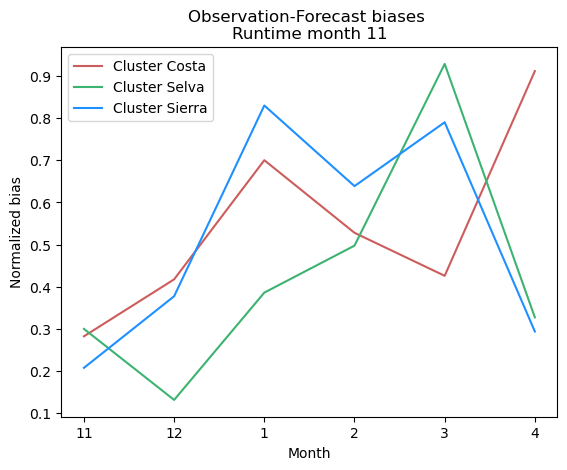

Current runtime _____________________________________________________________ 

Runtime month: 12, until 5
[########################################] | 100% Completed | 12.07 s
_____________________________________________________________________________ 


Station PEDRO CANGA, cluster costa
Latitude: -3.553°, Longitude: -80.381° 

Forecast 
Latitude: -3.55416666666666°, Longitude: -80.37916666666666° 

Accuracy for the contingency table rain/no rain: 100.00 %

Evaluation of the model for each month: 
['wrong forecast - above', 'good forecast - overestimate', 'good forecast - overestimate', 'wrong forecast - above', 'wrong forecast - above']

_____________________________________________________________________________ 


Station CAPITAN MONTES, cluster costa
Latitude: -4.577°, Longitude: -81.254° 

Forecast 
Latitude: -4.579166666666666°, Longitude: -81.25416666666666° 

Accuracy for the contingency table rain/no rain: 50.00 %

Evaluation of the model for each month: 
['good forecast 

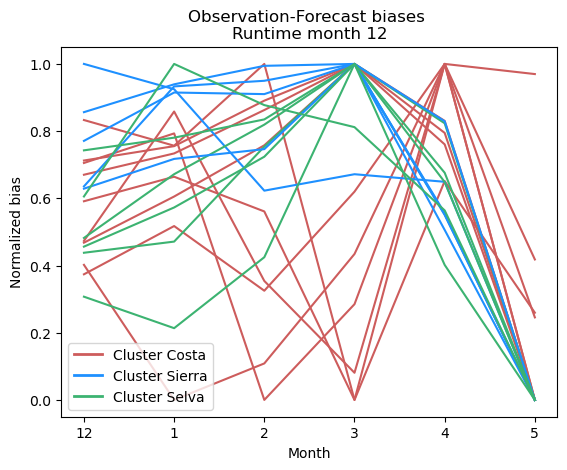

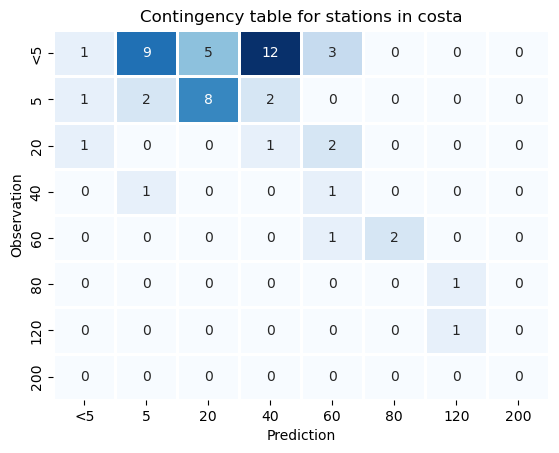

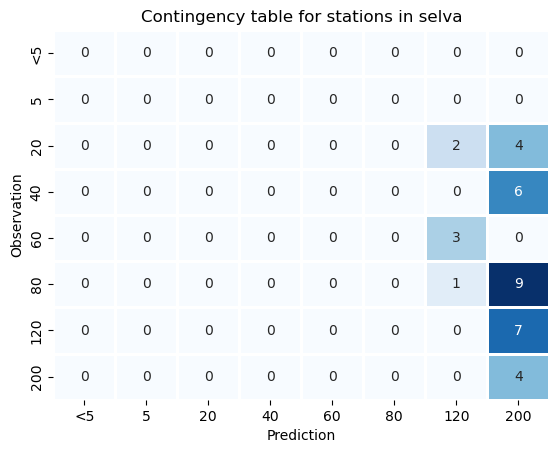

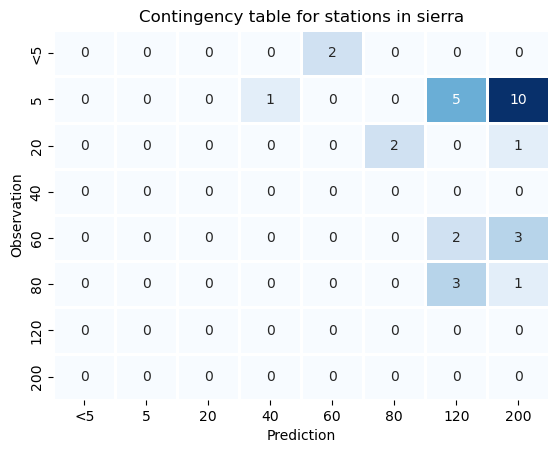

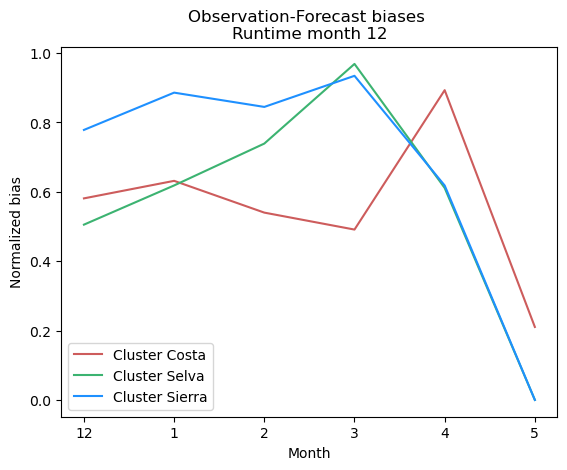

In [28]:
for month in range (1,13):
    monthly_tp(month)
    map_month(month)